In [1]:
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

In [45]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import stats
from scipy.spatial import distance

DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM pHYs 41 9
DEBUG:PIL.PngImagePlugin:STREAM gAMA 62 4
DEBUG:PIL.PngImagePlugin:STREAM cHRM 78 32
DEBUG:PIL.PngImagePlugin:cHRM 78 32 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM IDAT 122 70981


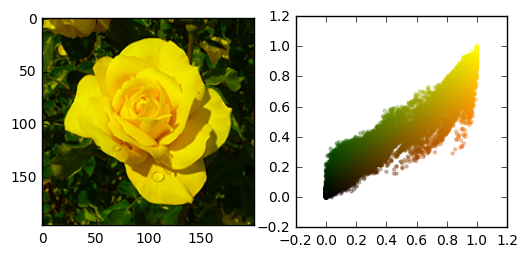

In [4]:
img = ndimage.io.imread('12-Rosa_Gold_Glow_2_small_noblue.png')/255.

plt.subplot(121)
plt.imshow(img)

im_flat = img.reshape([-1, 3])
plt.subplot(122)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.axis('square')
None

In [5]:
# use K-means to quantize the colors

In [6]:
N, D = im_flat.shape

Iteration: 0 Loss: 120.204
Iteration: 10 Loss: 84.5972
Iteration: 20 Loss: 77.5496
Iteration: 30 Loss: 75.3763
Iteration: 40 Loss: 74.5783
Iteration: 50 Loss: 74.0043
Iteration: 60 Loss: 73.4029
Iteration: 70 Loss: 73.0263
Iteration: 80 Loss: 72.959
Iteration: 90 Loss: 72.9533


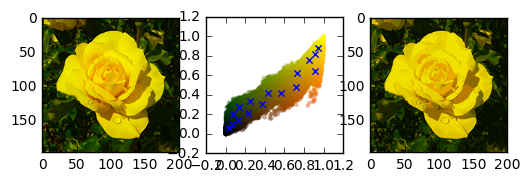

In [7]:
K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in xrange(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

Iteration: 0 Loss: 326
Iteration: 100000 Loss: 141.085
Iteration: 200000 Loss: 141.117
Iteration: 300000 Loss: 141.063
Iteration: 400000 Loss: 140.83
Iteration: 500000 Loss: 141.033
Iteration: 600000 Loss: 141.157
Iteration: 700000 Loss: 140.762
Iteration: 800000 Loss: 141.431
Iteration: 900000 Loss: 140.603


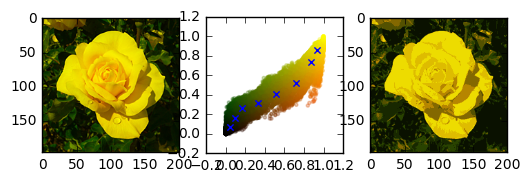

In [8]:
# An on-line version of k-Means

K = 8
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 1e-2
for i in range(1000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    centers[cluster_id] = (1 - alpha) * centers[cluster_id] + alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

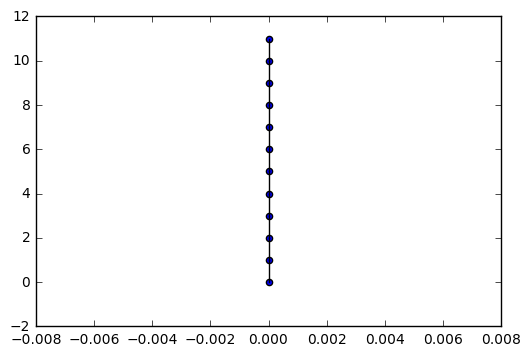

In [9]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

NY, NX = np.meshgrid(np.arange(1), np.arange(12))
neuron_topology = np.stack([NY.ravel(), NX.ravel()], axis=1)

K = neuron_topology.shape[0]

C = np.zeros((K, K))
for ni in xrange(K):
    for nj in xrange(K):
        C[ni, nj] = np.maximum(0.0, 
                               1.0 - np.abs(neuron_topology[ni] - neuron_topology[nj]).sum()/2.0)

def plot_lines(C, locations, **kwargs):
    segments = []
    for ni, nj in zip(*np.nonzero(C)):
        if ni < nj:
            segments.append(locations[ni])
            segments.append(locations[nj])
            segments.append(np.zeros((2,)) + np.nan)
    segments = np.array(segments)
    plt.plot(segments[:,0], segments[:,1], **kwargs)

plt.scatter(neuron_topology[:,0], neuron_topology[:,1])
plot_lines(C, neuron_topology, color='k')

In [10]:
C

Shape: (12, 12)
[[ 1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1. ]]

Iteration: 0 Loss: 214.943
Iteration: 100000 Loss: 108.899
Iteration: 200000 Loss: 107.612
Iteration: 300000 Loss: 109.344
Iteration: 400000 Loss: 109.052
Iteration: 500000 Loss: 111.383
Iteration: 600000 Loss: 110.318
Iteration: 700000 Loss: 108.019
Iteration: 800000 Loss: 109.419
Iteration: 900000 Loss: 109.535
Iteration: 1000000 Loss: 109.106
Iteration: 1100000 Loss: 107.393
Iteration: 1200000 Loss: 111.68
Iteration: 1300000 Loss: 108.059
Iteration: 1400000 Loss: 108.479
Iteration: 1500000 Loss: 108.428
Iteration: 1600000 Loss: 109.814
Iteration: 1700000 Loss: 110.014
Iteration: 1800000 Loss: 108.964
Iteration: 1900000 Loss: 110.419
Iteration: 2000000 Loss: 110.469
Iteration: 2100000 Loss: 111.247
Iteration: 2200000 Loss: 107.603
Iteration: 2300000 Loss: 109.635
Iteration: 2400000 Loss: 108.312
Iteration: 2500000 Loss: 108.306
Iteration: 2600000 Loss: 110.2
Iteration: 2700000 Loss: 107.55
Iteration: 2800000 Loss: 106.28
Iteration: 2900000 Loss: 107.341


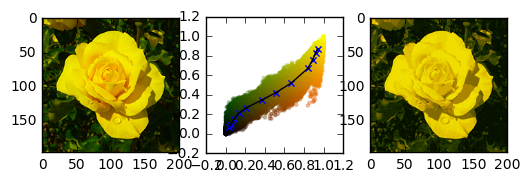

In [11]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 2e-2
for i in range(3000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    cluster_alpha = (alpha * C[cluster_id]).reshape([-1, 1])
    centers = (1 - cluster_alpha) * centers + cluster_alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

(-0.20000000000000001,
 1.2000000000000002,
 -0.20000000000000001,
 1.2000000000000002)

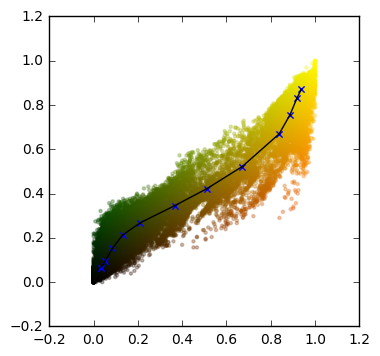

In [12]:
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')

# Fitting a Gaussian mixture using EM

In [46]:
def make_ellipse(mean, cov, ax, **kwargs):
    kwargs.setdefault('alpha', 0.5)
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, **kwargs)
    ell.set_clip_box(ax.bbox)
    ax.add_artist(ell)

In [138]:
# first run a k-means to initialize
K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in xrange(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

Iteration: 0 Loss: 115.15
Iteration: 10 Loss: 88.4704
Iteration: 20 Loss: 81.1447
Iteration: 30 Loss: 78.564
Iteration: 40 Loss: 77.808
Iteration: 50 Loss: 77.5696
Iteration: 60 Loss: 77.5363


In [143]:
im_flat_2D = im_flat[:, :2]

# randomly select centers
K = 16
initial_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat_2D[initial_center_ids, :]
sigmas = np.array([np.cov(im_flat_2D.T)] * K)
phis = np.ones((K,)) / K

# copy init from k-means
if 1:
    centers = centers[:, :2]

# copy init from sklearn - for debugging
if 0:
    phis = np.array(gmm.weights_)
    centers = np.array(gmm.means_)
    sigmas = np.array(gmm.covars_)

min_covar = 0
    
old_log_likelihood = np.inf
for i in range(100):
    # E step
    log_prob_z_and_x = []
    for k in range(K):
        log_prob_z_and_x.append(stats.multivariate_normal.logpdf(im_flat_2D, mean=centers[k,:], cov=sigmas[k]) +
                                np.log(phis[k]))
    log_prob_z_and_x = np.array(log_prob_z_and_x)
    
    prob_z_given_x = np.exp(log_prob_z_and_x - np.max(log_prob_z_and_x, 0, keepdims=True))
    Q = prob_z_given_x = prob_z_given_x / prob_z_given_x.sum(0, keepdims=True)
    
    log_likelihood = np.log(np.exp(log_prob_z_and_x).sum(0)).sum()
    if not i%1:
        print ("Iteration: %d log-likelihood: %g" % (i, log_likelihood))
    
    if log_likelihood >= old_log_likelihood:
        pass
        #break
    old_log_likelihood = log_likelihood

    # M step
    w = prob_z_given_x
    phis = w.mean(1)
    
    for k in xrange(K):
        w_sum = sum(w[k])
        centers[k] = (im_flat_2D * w[k, :, None]).sum(0) / w_sum
        deviation_from_center = im_flat_2D - centers[k]
        sigmas[k] = deviation_from_center.T.dot(deviation_from_center * w[k, :, None]) / w_sum
        sigmas[k][np.arange(2), np.arange(2)] = np.maximum(min_covar, sigmas[k][np.arange(2), np.arange(2)])

Iteration: 0 log-likelihood: 24796.6
Iteration: 1 log-likelihood: 38797
Iteration: 2 log-likelihood: 53722.2
Iteration: 3 log-likelihood: 67237.8
Iteration: 4 log-likelihood: 74327.9
Iteration: 5 log-likelihood: 78457.7
Iteration: 6 log-likelihood: 80287.5
Iteration: 7 log-likelihood: 81084.2
Iteration: 8 log-likelihood: 81591.9
Iteration: 9 log-likelihood: 81992.7
Iteration: 10 log-likelihood: 82305
Iteration: 11 log-likelihood: 82526.5
Iteration: 12 log-likelihood: 82675.5
Iteration: 13 log-likelihood: 82779.9
Iteration: 14 log-likelihood: 82861.2
Iteration: 15 log-likelihood: 82932.4
Iteration: 16 log-likelihood: 83000.7
Iteration: 17 log-likelihood: 83071.1
Iteration: 18 log-likelihood: 83147
Iteration: 19 log-likelihood: 83230.9
Iteration: 20 log-likelihood: 83323.4
Iteration: 21 log-likelihood: 83420
Iteration: 22 log-likelihood: 83509.9
Iteration: 23 log-likelihood: 83583.9
Iteration: 24 log-likelihood: 83641.4
Iteration: 25 log-likelihood: 83687
Iteration: 26 log-likelihood: 83

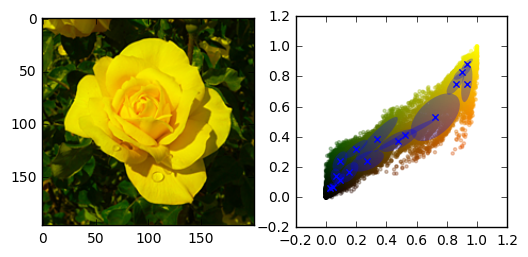

In [144]:
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.scatter(im_flat_2D[:,0], im_flat_2D[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

for mean, cov in zip(centers, sigmas):
    make_ellipse(mean, cov, plt.gca(), edgecolor='none', alpha=0.3)
None

In [27]:
from sklearn import mixture

In [128]:
gmm = mixture.GMM(n_components=16, covariance_type='full', min_covar=1e-3)
gmm.fit(im_flat_2D)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=16, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

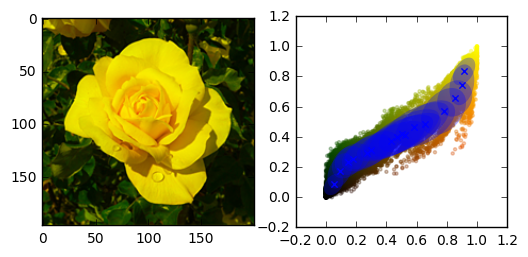

In [129]:
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.scatter(im_flat_2D[:,0], im_flat_2D[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x')
plt.axis('square')

for mean, cov in zip(gmm.means_, gmm.covars_):
    make_ellipse(mean, cov, plt.gca(), edgecolor='none', alpha=0.3)
None

In [123]:
import sklearn
sklearn.__version__

'0.17.1'